In [2]:
!pip install cplex

In [3]:
!pip install docplex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 633.5/633.5 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docplex: filename=docplex-2.25.236-py3-none-any.whl size=671350 sha256=35df3214e84eb5f61bcc9e6cf4be3e2c06ae4e5abab5a7efc2925229c053fc03
  Stored in directory: /root/.cache/pip/wheels/3b/e5/00/0bf0173d67188fe73a13e3a61412b3f975f60205e3fab93a69
Successfully built docplex


In [4]:
!pip install pandas

# New section

In [ ]:
from cplex.callbacks import LazyConstraintCallback
from docplex.mp.callbacks.cb_mixin import *
from docplex.mp.model import Model
import numpy as np
import matplotlib.pyplot as plt
import requests

In [5]:

import requests
import numpy as np

def parse_vrp_instance(url, num_nodes):
    response = requests.get(url)

    if response.status_code == 200:
        content = response.text
        lines = content.split('\n')
        node_coord_index = lines.index('NODE_COORD_SECTION ')
        node_coord_lines = lines[node_coord_index + 1:]  # Start from NODE_COORD_SECTION

        # Parse the coordinates and reindex
        matrix_coord = []
        index = 0
        for line in node_coord_lines:
            values = line.split()
            if len(values) == 3:  # Ensure there are 3 values per line (index, x, y)
                x = int(values[1])
                y = int(values[2])
                matrix_coord.append([index, x, y])  # Append integer index
                index += 1
                if index == num_nodes:
                    break  # Stop parsing once desired number of nodes is reached

        return np.array(matrix_coord)
    else:
        print("Failed to retrieve VRP instance.")
        return None




## Get data

In [28]:
url = 'http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n32-k5.vrp'
num_nodes = 15  # Decide the size of the matrix (number of nodes)
matrix_coord = parse_vrp_instance(url, num_nodes)
# initial cycle
alpha =0.5
beta =8.9

In [6]:

import matplotlib.pyplot as plt

def scatter_sommets(points1, points2, extra_point=None, connections_matrix1=None, connections_matrix2=None,
                    objective_value=None,color1='blue', color2='red', extra_color='green', line_color1='blue', line_color2='green'):
    if len(points1) > 0:
        if len(points1.shape) == 1:  # Handle single point
            plt.scatter(points1[1], points1[2], marker='o', label='Cycle', color=color1)
            plt.annotate(f"{points1[0]}", (points1[1], points1[2]), textcoords="offset points", xytext=(0, 5), ha='center')
        else:
            plt.scatter(points1[:, 1], points1[:, 2], marker='o', label='Cycle', color=color1)
            for point in points1:
                plt.annotate(f"{point[0]}", (point[1], point[2]), textcoords="offset points", xytext=(0, 5), ha='center')
    if points2 is not None:
      if len(points2) > 0:
          if len(points2.shape) == 1:  # Handle single point
              plt.scatter(points2[1], points2[2], marker='o', label='Point_not_eval', color=color2)
              plt.annotate(f"{points2[0]}", (points2[1], points2[2]), textcoords="offset points", xytext=(0, -15), ha='center')
          else:
              plt.scatter(points2[:, 1], points2[:, 2], marker='o', label='Sommets_non_eval ', color=color2)
              for point in points2:
                  plt.annotate(f"{point[0]}", (point[1], point[2]), textcoords="offset points", xytext=(0, -15), ha='center')

    # Scatter the extra point if provided
    if extra_point is not None:
        plt.scatter(extra_point[1], extra_point[2], marker='o', label='Next Point', color=extra_color)
        plt.annotate(f"{extra_point[0]}", (extra_point[1], extra_point[2]), textcoords="offset points", xytext=(0, 5), ha='center')

   # Plot lines between points based on connections_matrix1 if provided
    if connections_matrix1 is not None:
        for i in points1:
            for j in points1:
                if connections_matrix1[i[0]][j[0]] == 1:
                    plt.plot([i[1],j[1]], [i[2],j[2]], color=line_color1)

    # Plot lines between points based on connections_matrix2 if provided
    if connections_matrix2 is not None:
        for i in points1:
            for j in points2:
                if connections_matrix2[i[0]][j[0]] == 1:
                    plt.plot([i[1], j[1]], [i[2], j[2]], color=line_color2)


    if objective_value is not None:
        plt.text(0.1, 0.95, f'Objective Value: {objective_value}', transform=plt.gca().transAxes,
                 fontsize=10, verticalalignment='top', horizontalalignment='left')
    # Set axis labels
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    # Set grid size
    plt.xlim(-10, 150)
    plt.ylim(-10, 150)

    # Add a grid
    plt.grid(True, linestyle='--', alpha=0.7)

    # Show the plot
    plt.legend()
    plt.show()





In [7]:
def instance_rsp(matrix_coord,alpha):
    size_matrix = len(matrix_coord)
    distance_matrix = np.zeros((size_matrix, size_matrix))

    for i in range(size_matrix):
        for j in range(i+1, size_matrix):
            # Extract coordinates for points i and j
            x1, y1 = matrix_coord[i, 1], matrix_coord[i, 2]
            x2, y2 = matrix_coord[j, 1], matrix_coord[j, 2]

            # Calculate Euclidean distance between points i and j
            distance_ij = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

            # Fill in the distance matrix
            distance_matrix[i, j] = np.round(distance_ij, 2)
            distance_matrix[j, i] = np.round(distance_ij, 2)

    c_matrix = alpha*distance_matrix
    d_matrix = (10-alpha)*distance_matrix

    return c_matrix, d_matrix


In [8]:
def generate_sol(size_problem):
    X = np.random.randint(2, size=(size_problem,size_problem))
    Y = np.random.randint(2, size=(size_problem,size_problem))
    return X,Y

In [9]:
def get_min_k(cycle, sommet_non_eval, C,D):
    min_k_costs = []  # Dictionary to store minimum insertion cost for each vertex in sommet_non_eval

    # If the cycle contains only one point, calculate insertion cost directly
    if len(cycle) == 1:
        cycle_idx = cycle[0][0]

        # Calculate insertion cost for each vertex in sommet_non_eval
        for vertex in sommet_non_eval:
            d_k =0
            k_idx = vertex[0]
            insertion_cost = C[k_idx][cycle_idx] * 2  # Cost to connect k to the only point in cycle
            for second_vertex in sommet_non_eval:
                k2_idx =second_vertex[0]
                if k_idx != k2_idx:
                    d_k +=D[k_idx][k2_idx]
            insertion_cost+=d_k
            min_k_costs.append([k_idx,insertion_cost])



    else:
        # Calculate insertion cost for each vertex k between vertices in cycle
        for vertex in sommet_non_eval:
            d_k =0
            k_idx = vertex[0]
            min_cost_for_k = float('inf')  # Initialize minimum insertion cost for vertex k

            for i in cycle:
                i_idx = i[0]
                for j in cycle:
                    j_idx = j[0]
                    if i_idx != j_idx:
                        # Calculate insertion cost for vertex k between vertices i and j
                        insertion_cost = C[i_idx][k_idx] + C[k_idx][j_idx] - C[i_idx][j_idx]
                        # Update minimum insertion cost for vertex k with respect to points in cycle
                        if insertion_cost < min_cost_for_k:
                            min_cost_for_k = insertion_cost

            # Store the minimum insertion cost for vertex k along with its index
            for second_vertex in sommet_non_eval:
                k2_idx =second_vertex[0]
                if k_idx != k2_idx:
                    d_k +=D[k_idx][k2_idx]
            min_cost_for_k+=d_k
            min_k_costs.append([k_idx,insertion_cost])

    return min_k_costs


In [10]:
import numpy as np

def get_point_from_sommet_non_val(g_values, sommet_non_eval, alpha):
    min_g = min(g_values, key=lambda x: x[1])[1]
    max_g = max(g_values, key=lambda x: x[1])[1]
    min_threshold = min_g + alpha * (max_g - min_g)

    # Select indices of points within the specified range
    indices_within_range = [point[0] for point in g_values if point[1] <= min_threshold]

    # Randomly select one index from the selected indices
    random_index = np.random.choice(indices_within_range)
    corresponding_row = [row for row in sommet_non_eval if row[0] == random_index]

    return corresponding_row[0]



In [11]:
def AC(cycle,C,size):
    # cycle
    matrix_of_c =  np.zeros((size, size))
    AC = 0
    l = len(cycle)
    if l > 1:

        for i in range(l -1):
                index1 = cycle[i][0]
                index2 = cycle[i+1][0]

                AC += C[index1][index2]

                matrix_of_c[index1][index2] = 1
                matrix_of_c[index2][index1] = 1

        AC +=C[index2][cycle[0][0]]
        matrix_of_c[index2][cycle[0][0]]=1
        matrix_of_c[cycle[0][0]][index2] = 1
    else:
        matrix_of_c[cycle[0][0]][cycle[0][0]]=1

    return AC, matrix_of_c


In [12]:
def LC(sommet_non_eval,cycle,D,size):
    LC = 0

    matrix_of_cs =  np.zeros((size, size))
    if len(cycle)==1:
        #print("here sommet:",sommet_non_eval)
        for point in sommet_non_eval:
            #print(cycle[0][0],point[0])
            LC += D[cycle[0][0]][point[0]]
            matrix_of_cs[cycle[0][0]][point[0]] = 1
            matrix_of_cs[point[0]][cycle[0][0]] = 1
    else:
        for point in sommet_non_eval:
            min_price_point =np.max(D)
            index = cycle[0][0]
            for point_cycle in cycle:
                if D[point[0]][point_cycle[0]] < min_price_point :
                    min_price_point = D[point[0]][point_cycle[0]]
                    index = point_cycle[0]
            matrix_of_cs[point[0]][index]=1
            matrix_of_cs[index][point[0]]=1

            LC += min_price_point
    return LC,matrix_of_cs







In [14]:

def find_index_new_point(point, cycle, C):

    if len(cycle) == 1:
        return 0

    point_index = point[0]
    min_distance = 2 * np.max(C)
    n = len(cycle)
    index = 0
    #print(cycle)
    for i in range(n):
        i_index = cycle[i%n][0]
        next_index = cycle[(i + 1)%n][0]

        #print(i,(i+1)%n,min_distance,C[point_index][i_index] + C[point_index][next_index]-C[i_index][next_index])
        if C[point_index][i_index] + C[point_index][next_index]-C[i_index][next_index] < min_distance:
            min_distance = C[point_index][i_index] + C[point_index][next_index]-C[i_index][next_index]
            index = i
            #print(index)

    return index+1


'''def move_point(point, source_array, destination_array,index):
    point_id = point[0]
    index = np.where(source_array[:, 0] == point_id)[0]
    if len(index) > 0:
        destination_array = np.append(destination_array, [point], axis=0)
        source_array = np.delete(source_array, index, axis=0)
    else:
        print("Point not found in the source array.")
    return source_array, destination_array

'''

def move_point(point, source_array, destination_array, index = 0):
    point_id = point[0]
    index_source = np.where(source_array[:, 0] == point_id)[0]
    if len(index_source) > 0:
        # Extract the point from source array
        point_to_move = source_array[index_source[0]]

        # Insert the point into destination array at the specified index
        #print(destination_array)
        if index > len(destination_array):
            destination_array=np.vstack([destination_array,point_to_move])
        else:
            destination_array = np.insert(destination_array, index, point_to_move, axis=0)
        #print(destination_array)
        # Remove the point from source array
        source_array = np.delete(source_array, index_source, axis=0)
    else:
        print("Point not found in the source array.")
    return source_array, destination_array


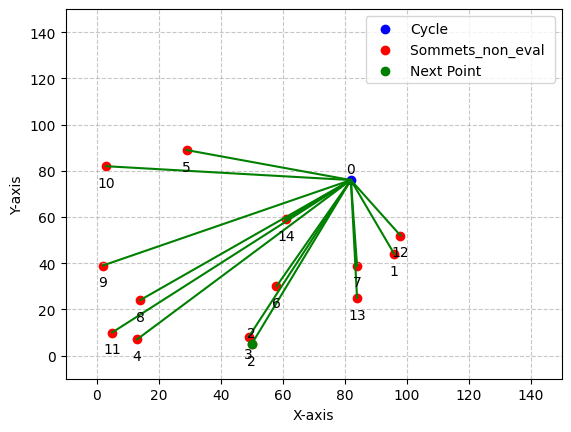

Objective = 5344.5


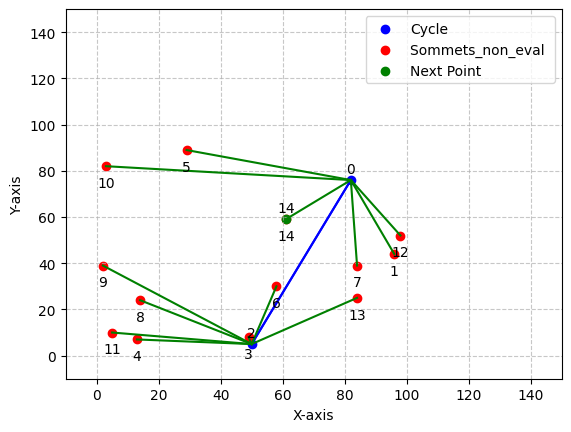

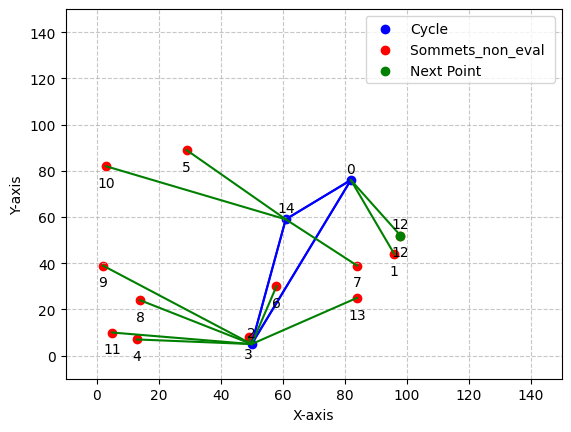

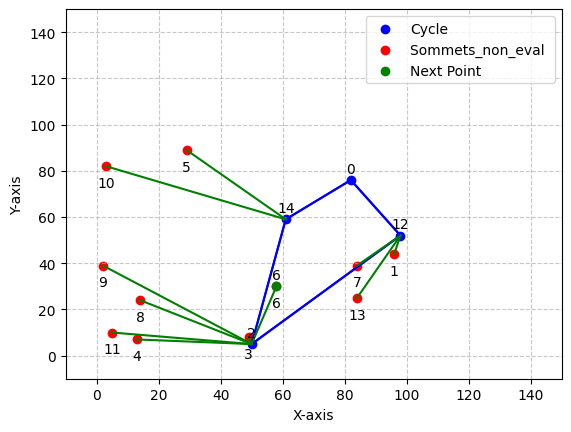

Interact Objective = 3307.08
Objective = 3307.08


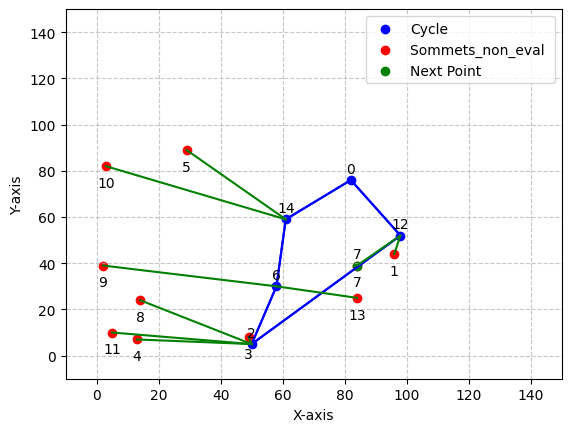

Interact Objective = 3117.6000000000004
Objective = 3117.6000000000004


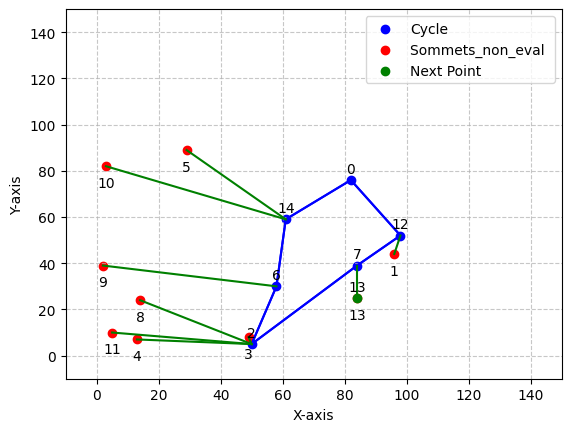

Interact Objective = 3071.1900000000005
Objective = 3071.1900000000005


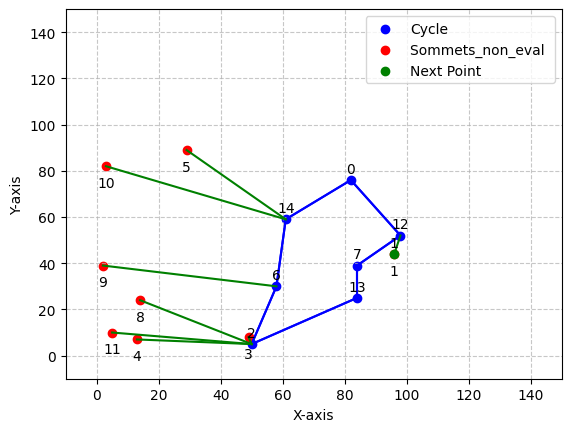

Interact Objective = 3036.7400000000002
Objective = 3036.7400000000002


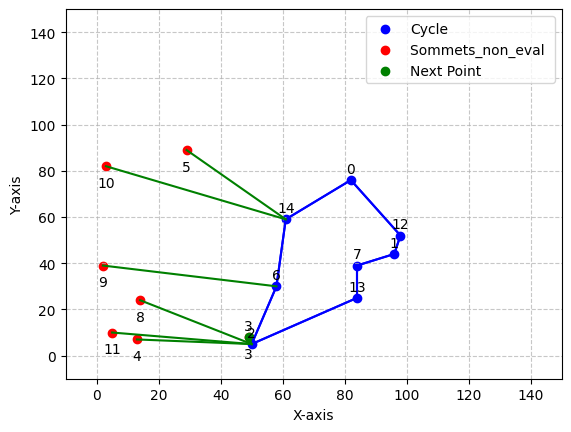

Interact Objective = 2993.0199999999995
Objective = 2993.0199999999995


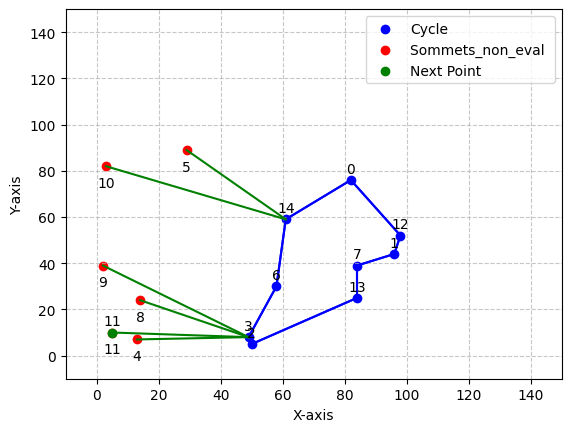

Interact Objective = 2808.4700000000003
Objective = 2808.4700000000003


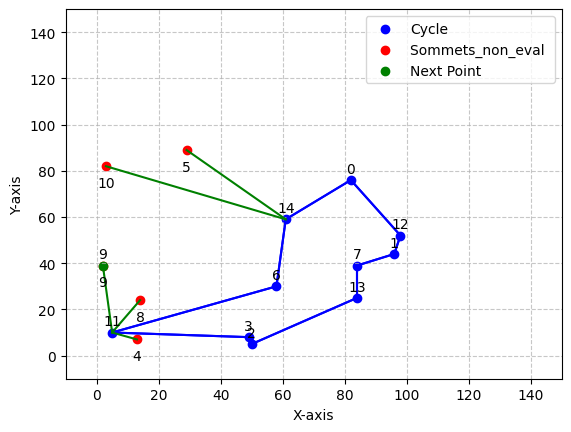

Interact Objective = 2721.83
Objective = 2721.83


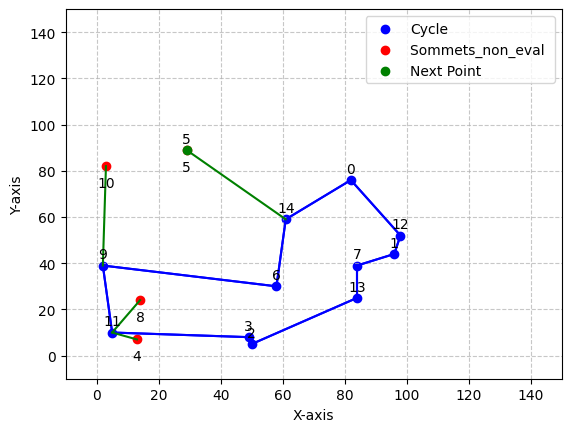

Interact Objective = 2823.07


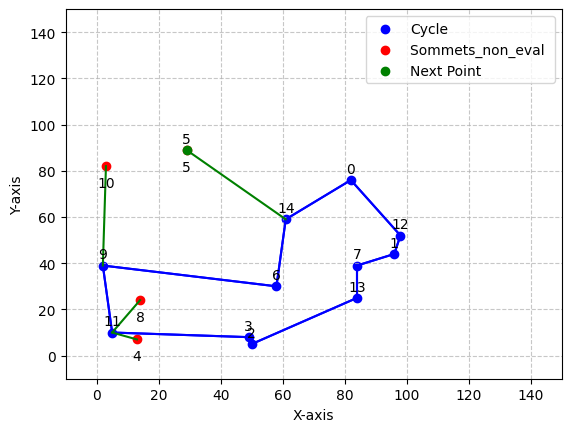

In [17]:
url = 'http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n32-k5.vrp'
num_nodes = 15  # Decide the size of the matrix (number of nodes)
matrix_coord = parse_vrp_instance(url, num_nodes)
# initial cycle
alpha =0.5
beta =8.9
size = len(matrix_coord)
cycle = matrix_coord[0].reshape(1, -1)
sommet_non_eval = matrix_coord[1:,:]
C,D = instance_rsp(matrix_coord, beta)
price_cs, matrix_cs = LC(sommet_non_eval,cycle,D,len(matrix_coord))
price_cycle,matrix_c = AC(cycle,C,len(matrix_coord))
g_min = get_min_k(cycle, sommet_non_eval,C,D)
next_point = get_point_from_sommet_non_val(g_min, sommet_non_eval, alpha)
scatter_sommets(cycle, sommet_non_eval,next_point, matrix_c, matrix_cs)
min_objective = price_cycle + 2*price_cs
print(f"Objective = {min_objective}")
delta = 0
while delta <= 0 and len(cycle) < size:
    if len(cycle)<4:

        index = find_index_new_point(next_point,cycle,C)
        sommet_non_eval, cycle = move_point(next_point, sommet_non_eval, cycle,index)
        price_cs, matrix_cs = LC(sommet_non_eval,cycle,D,len(matrix_coord))
        price_cycle,matrix_c = AC(cycle,C,len(matrix_coord))
        g_min = get_min_k(cycle, sommet_non_eval,C,D)
        next_point = get_point_from_sommet_non_val(g_min, sommet_non_eval, alpha)
        scatter_sommets(cycle, sommet_non_eval,next_point, matrix_c, matrix_cs)
    else:


        index = find_index_new_point(next_point,cycle,C)
        sommet_non_eval, cycle = move_point(next_point, sommet_non_eval, cycle,index)
        price_cs, matrix_cs = LC(sommet_non_eval,cycle,D,len(matrix_coord))
        price_c,matrix_c = AC(cycle,C,len(matrix_coord))
        interact_objective = price_c + 2*price_cs
        print(f"Interact Objective = {interact_objective}")
        delta = interact_objective -min_objective
        if delta > 0:
            cycle, sommet_non_eval = move_point(next_point, cycle,sommet_non_eval,0)
            price_cs, matrix_cs = LC(sommet_non_eval,cycle,D,len(matrix_coord))
            price_cycle,matrix_c = AC(cycle,C,len(matrix_coord))
            scatter_sommets(cycle, sommet_non_eval,next_point, matrix_c, matrix_cs)
        else:
            min_objective = interact_objective
            print(f"Objective = {min_objective}")
            g_min = get_min_k(cycle, sommet_non_eval,C,D)
            next_point = get_point_from_sommet_non_val(g_min, sommet_non_eval, alpha)
            scatter_sommets(cycle, sommet_non_eval,next_point, matrix_c, matrix_cs)



In [18]:
def my_function(matrix_coord_f, alpha_f=0.8, beta_f=7):
    # initial cycle
    size_f = len(matrix_coord_f)
    cycle_f = matrix_coord_f[0].reshape(1, -1)
    sommet_non_eval_f = matrix_coord_f[1:,:]

    C_f, D_f = instance_rsp(matrix_coord_f, beta_f)
    #print("len_C",len(C_f),"len_D",len(D_f),"len_matrix",len(matrix_coord_f),"len_sommet",len(sommet_non_eval_f ))
    price_cs_f, matrix_cs_f = LC(sommet_non_eval_f, cycle_f, D_f, size_f)
    price_cycle_f, matrix_c_f = AC(cycle_f, C_f, size_f)
    g_min_f = get_min_k(cycle_f, sommet_non_eval_f, C_f, D_f)
    next_point_f = get_point_from_sommet_non_val(g_min_f, sommet_non_eval_f, alpha_f)
    #scatter_sommets(cycle_f, sommet_non_eval_f, next_point_f, matrix_c_f, matrix_cs_f)
    min_objective_f = price_cycle_f + 2 * price_cs_f
    #print(f"Objective = {min_objective_f}")
    delta_f = 0
    while delta_f <= 0 and len(cycle_f) < size_f:
        if len(cycle_f) < 4:
            index_f = find_index_new_point(next_point_f, cycle_f, C_f)
            sommet_non_eval_f, cycle_f = move_point(next_point_f, sommet_non_eval_f, cycle_f, index_f)
            price_cs_f, matrix_cs_f = LC(sommet_non_eval_f, cycle_f, D_f, size_f)
            price_cycle_f, matrix_c_f = AC(cycle_f, C_f, size_f)
            g_min_f = get_min_k(cycle_f, sommet_non_eval_f, C_f, D_f)
            next_point_f = get_point_from_sommet_non_val(g_min_f, sommet_non_eval_f, alpha_f)
            #scatter_sommets(cycle_f, sommet_non_eval_f, next_point_f, matrix_c_f, matrix_cs_f)
        else:
            index_f = find_index_new_point(next_point_f, cycle_f, C_f)
            sommet_non_eval_f, cycle_f = move_point(next_point_f, sommet_non_eval_f, cycle_f, index_f)
            price_cs_f, matrix_cs_f = LC(sommet_non_eval_f, cycle_f, D_f, size_f)
            price_c_f, matrix_c_f = AC(cycle_f, C_f, size_f)
            interact_objective_f = price_c_f + 2 * price_cs_f
            #print(f"Interact Objective = {interact_objective_f}")
            delta_f = interact_objective_f - min_objective_f
            if delta_f > 0:
                cycle_f, sommet_non_eval_f = move_point(next_point_f, cycle_f, sommet_non_eval_f, 0)
                price_cs_f, matrix_cs_f = LC(sommet_non_eval_f, cycle_f, D_f, size_f)
                price_cycle_f, matrix_c_f = AC(cycle_f, C_f, size_f)
                #scatter_sommets(cycle_f, sommet_non_eval_f, next_point_f, matrix_c_f, matrix_cs_f)
            else:
                min_objective_f = interact_objective_f
                #print(f"Objective = {min_objective_f}")
                g_min_f = get_min_k(cycle_f, sommet_non_eval_f, C_f, D_f)
                next_point_f = get_point_from_sommet_non_val(g_min_f, sommet_non_eval_f, alpha_f)
                #scatter_sommets(cycle_f, sommet_non_eval_f, next_point_f, matrix_c_f, matrix_cs_f)

    return C_f, D_f, cycle_f, sommet_non_eval_f, matrix_c_f, matrix_cs_f, min_objective_f

#matrix_coord

In [19]:
def swap_rows_2_opt(array, i, j):
     # Make a copy of the original array
    new_array = array.copy()
    # Swap the elements between indices i and j
    new_array[i+1:j][:] = array[j-1:i:-1][:]
    return new_array

In [20]:
def find_neighbor(cycle,sommet_non_eval,matrix_c,matrix_cs,min_objective,C,D):

    temp_cycle =cycle
    temp_sommet_non_eval = sommet_non_eval
    temp_price_cs =price_cs
    temp_price_cycle = price_cycle
    temp_matrix_c = matrix_c
    temp_matrix_cs = matrix_cs
    temp_min_objective = min_objective
    print("###########################################################################################")
    print('Performce add point to cycle----------------------------------------------')
    print(f"min objective = {min_objective}")
    changer_add = False
    for next_point in sommet_non_eval:
        #print(f"work on the point: {next_point[0]}")
        index = find_index_new_point(next_point,cycle,C)
        new_sommet_non_eval, new_cycle = move_point(next_point, sommet_non_eval, cycle,index)
        new_price_cs, new_matrix_cs = LC(new_sommet_non_eval,new_cycle,D,len(matrix_coord))
        new_price_cycle,new_matrix_c = AC(new_cycle,C,len(matrix_coord))
        interact_objective = new_price_cycle + 2*new_price_cs
        if temp_min_objective > interact_objective:
            changer_add = True
            temp_min_objective =interact_objective
            temp_cycle =new_cycle
            temp_sommet_non_eval = new_sommet_non_eval
            temp_price_cs =new_price_cs
            temp_price_cycle = new_price_cycle
            temp_matrix_c = new_matrix_c
            temp_matrix_cs = new_matrix_cs
            temp_index = next_point[0]
            #print(f"Found better solution, min objective = {temp_min_objective}")
            #scatter_sommets(temp_cycle, temp_sommet_non_eval,None, temp_matrix_c, temp_matrix_cs)

    if changer_add == True :
            print(f"Found better solution, min objective = {temp_min_objective}")
            print(f"Add point: {temp_index} to the cycle")
            scatter_sommets(temp_cycle, temp_sommet_non_eval,None, temp_matrix_c, temp_matrix_cs,temp_min_objective)
    else:
            print(f"Better solution not found(current objective = {temp_min_objective})")

    #""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    print("###########################################################################################")
    print('Performce remove point from cycle----------------------------------------------')
    print(f"min objective = {min_objective}")
    changer_remove = False
    for point in cycle:
        if point[0]!= 0:
            #print(f"work on the point: {point[0]}")
            new_cycle = cycle
            new_sommet_non_eval = sommet_non_eval
            new_cycle, new_sommet_non_eval  = move_point(point,new_cycle,new_sommet_non_eval)
            new_price_cs, new_matrix_cs = LC(new_sommet_non_eval,new_cycle,D,len(matrix_coord))
            new_price_cycle,new_matrix_c = AC(new_cycle,C,len(matrix_coord))
            interact_objective = new_price_cycle + 2*new_price_cs

        if temp_min_objective > interact_objective:
            changer_remove = True
            temp_min_objective =interact_objective
            temp_cycle =new_cycle
            temp_sommet_non_eval = new_sommet_non_eval
            temp_price_cs =new_price_cs
            temp_price_cycle = new_price_cycle
            temp_matrix_c = new_matrix_c
            temp_matrix_cs = new_matrix_cs
            temp_index = point[0]
            #print(f"Found better solution, min objective = {temp_min_objective}")
            #scatter_sommets(temp_cycle, temp_sommet_non_eval,None, temp_matrix_c, temp_matrix_cs)

    if changer_remove == True :
            print(f"Found better solution, min objective = {temp_min_objective}")
            print(f"Remove point: {temp_index} from the cycle")
            scatter_sommets(temp_cycle, temp_sommet_non_eval,None, temp_matrix_c, temp_matrix_cs,temp_min_objective)
    else:
            print(f"Better solution not found(current objective = {temp_min_objective})")
     #""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    print("###########################################################################################")
    print('Performce swap point from ----------------------------------------------')
    print(f"min objective = {min_objective}")
    changer_remove = False
    for point in cycle:
        if point[0]!= 0:
            for next_point in sommet_non_eval:
                #print(f"work on the point: {point[0]},{next_point[0]}")
                new_cycle = cycle
                new_sommet_non_eval = sommet_non_eval
                new_cycle, new_sommet_non_eval  = move_point(point,new_cycle,new_sommet_non_eval)
                new_price_cs, new_matrix_cs = LC(new_sommet_non_eval,new_cycle,D,len(matrix_coord))
                new_price_cycle,new_matrix_c = AC(new_cycle,C,len(matrix_coord))
                interact_objective = new_price_cycle + 2*new_price_cs

                index = find_index_new_point(next_point,new_cycle,C)
                new_sommet_non_eval, new_cycle = move_point(next_point, new_sommet_non_eval, new_cycle,index)
                new_price_cs, new_matrix_cs = LC(new_sommet_non_eval,new_cycle,D,len(matrix_coord))
                new_price_cycle,new_matrix_c = AC(new_cycle,C,len(matrix_coord))
                interact_objective = new_price_cycle + 2*new_price_cs
                #scatter_sommets(new_cycle, new_sommet_non_eval,None, new_matrix_c, new_matrix_cs,interact_objective)
            if temp_min_objective > interact_objective:
                changer_remove = True
                temp_min_objective =interact_objective
                temp_cycle =new_cycle
                temp_sommet_non_eval = new_sommet_non_eval
                temp_price_cs =new_price_cs
                temp_price_cycle = new_price_cycle
                temp_matrix_c = new_matrix_c
                temp_matrix_cs = new_matrix_cs
                temp_index1 = point[0]
                temp_index2 = next_point[0]
                #print(f"Found better solution, min objective = {temp_min_objective}")
                #scatter_sommets(temp_cycle, temp_sommet_non_eval,None, temp_matrix_c, temp_matrix_cs)

    if changer_remove == True :
            print(f"Found better solution, min objective = {temp_min_objective}")
            print(f"swap points: {temp_index1} from the cycle to {temp_index2} from the sommets")
            scatter_sommets(temp_cycle, temp_sommet_non_eval,None, temp_matrix_c, temp_matrix_cs,temp_min_objective)
    else:
            print(f"Better solution not found(current objective = {temp_min_objective})")

    #""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""



    #==================================================================================================
    print("###########################################################################################")
    print('Performce 2-opt for the cycle ----------------------------------------------')
    print(f"min objective of cycle = {temp_price_cycle}")
    size = len(temp_cycle)
    scatter_sommets(temp_cycle, None,None, temp_matrix_c, None,temp_price_cycle)
    change_2_opt = False
    #print(temp_price_cycle)
    for i in range(size-3):
      for j in range(i+3,size-1):

        temp_array = swap_rows_2_opt(temp_cycle,i,j)
        temp_AC, temp_matrix = AC(temp_array,C,len(matrix_coord))
        #print(temp_AC)
        #scatter_sommets(temp_array, None,None, temp_matrix, None,temp_AC)
        if temp_AC < temp_price_cycle:
            temp_cycle = temp_array.copy()
            temp_price_cycle = temp_AC
            #print(temp_price_cycle)
            #print("----------------------------------------------")
            temp_matrix_c = temp_matrix
            #print(i,j,temp_cycle[i][0],temp_cycle[j][0])
            #scatter_sommets(temp_cycle, None,None, temp_matrix_c, None,temp_price_cycle)
            change_2_opt = True
    if change_2_opt == True :
      print(f"Found better solution, min objective_cycle = {temp_price_cycle}")
      scatter_sommets(temp_cycle, None,None, temp_matrix_c, None,temp_price_cycle)
      temp_price_cs, temp_matrix_cs = LC(temp_sommet_non_eval,temp_cycle,D,len(matrix_coord))
      temp_price_cycle,temp_matrix_c = AC(temp_cycle,C,len(matrix_coord))
      interact_objective = temp_price_cycle + 2*temp_price_cs
      scatter_sommets(temp_cycle, temp_sommet_non_eval,None, temp_matrix_c, temp_matrix_cs,temp_min_objective)
    else:
      print(f"Better solution not found(current objective = {temp_price_cycle})")
      #scatter_sommets(temp_cycle, temp_sommet_non_eval,None, temp_matrix_c, temp_matrix_cs,temp_min_objective)




    return temp_cycle,temp_sommet_non_eval,temp_matrix_c,temp_matrix_cs,temp_min_objective

Initial solution: min objective = 2258.5750000000007


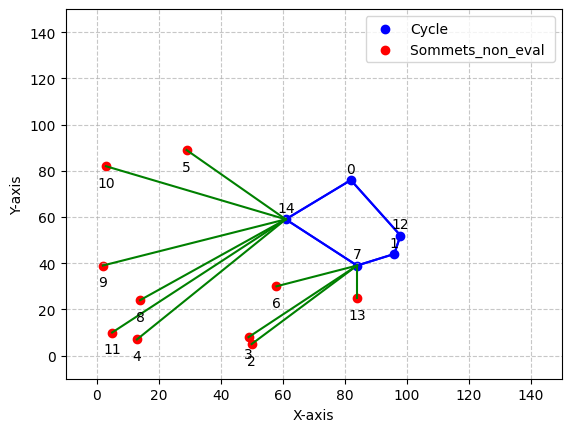

###########################################################################################
Performce add point to cycle----------------------------------------------
min objective = 2258.5750000000007
Better solution not found(current objective = 2258.5750000000007)
###########################################################################################
Performce remove point from cycle----------------------------------------------
min objective = 2258.5750000000007
Better solution not found(current objective = 2258.5750000000007)
###########################################################################################
Performce swap point from ----------------------------------------------
min objective = 2258.5750000000007
Better solution not found(current objective = 2258.5750000000007)
###########################################################################################
Performce 2-opt for the cycle ----------------------------------------------
min objective of cycle =

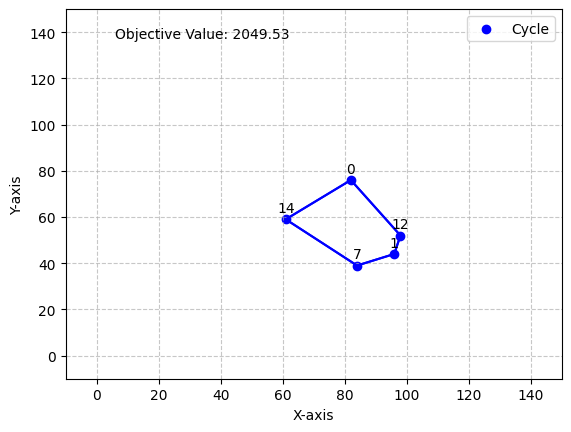

Found better solution, min objective_cycle = 860.8599999999999


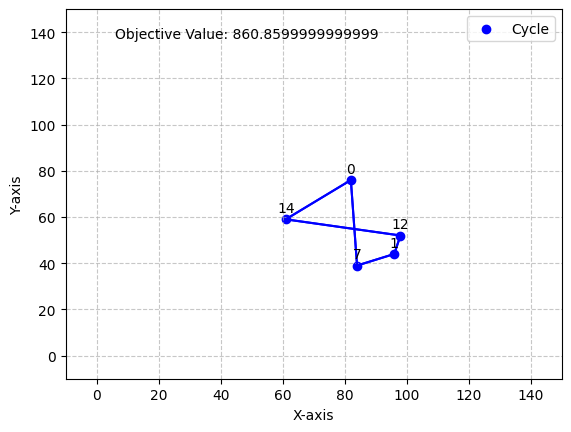

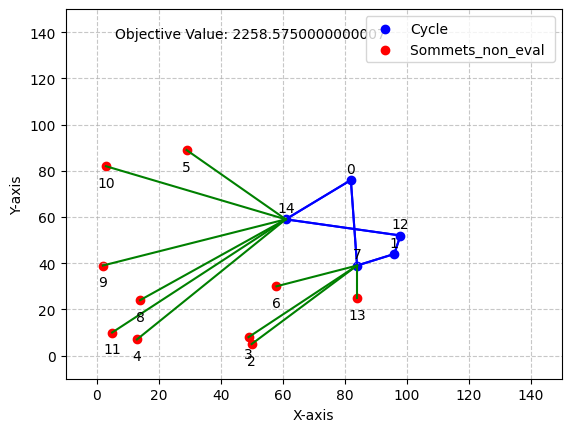

In [23]:
import time
alpha =0.2
beta =8.7

C1,D1, cycle1,sommet_non_eval1,matrix_c1,matrix_cs1,min_objective1 = my_function(matrix_coord,alpha,beta )
print(f'Initial solution: min objective = {min_objective1}')
scatter_sommets(cycle1, sommet_non_eval1,None, matrix_c1, matrix_cs1)

cycle2,sommet_non_eval2,matrix_c2,matrix_cs2,min_objective2 = find_neighbor(cycle1,
                                                                                   sommet_non_eval1,matrix_c1,
                                                                                   matrix_cs1,min_objective1,C,D)


In [24]:
import time
alpha =0.5
beta =8.7

best_min_objective = float('inf')  # Initialize best minimum objective with positive infinity
best_cycle = None
best_sommet_non_eval = None
best_matrix_c = None
best_matrix_cs = None
min_objectives = []
min_best=[]

start_time = time.time()
max_duration = 300  # 5 minutes in seconds

iterations = 50
for iter in range(iterations):
    print("############################################################################################################")
    print(f'Iterations:{iter}')

    C1, D1, cycle1, sommet_non_eval1, matrix_c1, matrix_cs1, min_objective1 = my_function(matrix_coord, alpha, beta)

    cycle2,sommet_non_eval2,matrix_c2,matrix_cs2,min_objective2 = find_neighbor(cycle1,
                                                                                   sommet_non_eval1,matrix_c1,
                                                                                   matrix_cs1,min_objective1,C,D)
    # Store the min objective value
    min_objectives.append(min_objective2)

    # Check if the current solution is the best so far
    if min_objective2 < best_min_objective:

        best_min_objective = min_objective2
        min_best.append(best_min_objective)
        best_cycle = cycle2
        best_sommet_non_eval = sommet_non_eval2
        best_matrix_c = matrix_c2
        best_matrix_cs = matrix_cs2

    # Check if time limit exceeded
    if time.time() - start_time > max_duration:
        print("Time limit exceeded. Exiting loop.")
        break

# Plot the best solution
print(f"Best solution found: min objective = {best_min_objective}")
scatter_sommets(best_cycle, best_sommet_non_eval, None, best_matrix_c, best_matrix_cs,best_min_objective)

# Plotting the min objective values
import matplotlib.pyplot as plt
print(f"Total time = {time.time() - start_time}")
plt.plot(range(1, len(min_objectives) + 1), min_objectives, marker='o', label='Min Objectives')
plt.plot(range(1, len(min_best) + 1), min_best, marker='x', color='red', label='Best Min Objectives')
plt.xlabel('Iteration')
plt.ylabel('Min Objective Value')
plt.title('Min Objective Value vs. Iteration')
plt.legend()
plt.grid(True)
plt.show()


Output hidden; open in https://colab.research.google.com to view.

# Find_neighbor without plot

In [27]:
def find_neighbor2(cycle,sommet_non_eval,matrix_c,matrix_cs,min_objective,C,D):

    temp_cycle =cycle
    temp_sommet_non_eval = sommet_non_eval
    temp_price_cs,_temp_matrix_cs =LC(temp_sommet_non_eval,temp_cycle,D,len(matrix_coord))
    temp_price_cycle,_temp_matrix_c =AC(temp_cycle,C,len(matrix_coord))
    temp_min_objective = min_objective
    #print("###########################################################################################")
    #print('Performce add point to cycle----------------------------------------------')
    #print(f"min objective = {min_objective}")
    changer_add = False
    for next_point in sommet_non_eval:
        #print(f"work on the point: {next_point[0]}")
        index = find_index_new_point(next_point,cycle,C)
        new_sommet_non_eval, new_cycle = move_point(next_point, sommet_non_eval, cycle,index)
        new_price_cs, new_matrix_cs = LC(new_sommet_non_eval,new_cycle,D,len(matrix_coord))
        new_price_cycle,new_matrix_c = AC(new_cycle,C,len(matrix_coord))
        interact_objective = new_price_cycle + 2*new_price_cs
        if temp_min_objective > interact_objective:
            changer_add = True
            temp_min_objective =interact_objective
            temp_cycle =new_cycle
            temp_sommet_non_eval = new_sommet_non_eval
            temp_price_cs =new_price_cs
            temp_price_cycle = new_price_cycle
            temp_matrix_c = new_matrix_c
            temp_matrix_cs = new_matrix_cs
            temp_index = next_point[0]
            #print(f"Found better solution, min objective = {temp_min_objective}")
            #scatter_sommets(temp_cycle, temp_sommet_non_eval,None, temp_matrix_c, temp_matrix_cs)

    if changer_add == True :
            print(f"Found better solution, min objective = {temp_min_objective}")
            print(f"Add point: {temp_index} to the cycle")
            #scatter_sommets(temp_cycle, temp_sommet_non_eval,None, temp_matrix_c, temp_matrix_cs,temp_min_objective)


    #""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    #print("###########################################################################################")
    #print('Performce remove point from cycle----------------------------------------------')
    #print(f"min objective = {min_objective}")
    changer_remove = False
    for point in cycle:
        if point[0]!= 0:
            #print(f"work on the point: {point[0]}")
            new_cycle = cycle
            new_sommet_non_eval = sommet_non_eval
            new_cycle, new_sommet_non_eval  = move_point(point,new_cycle,new_sommet_non_eval)
            new_price_cs, new_matrix_cs = LC(new_sommet_non_eval,new_cycle,D,len(matrix_coord))
            new_price_cycle,new_matrix_c = AC(new_cycle,C,len(matrix_coord))
            interact_objective = new_price_cycle + 2*new_price_cs

        if temp_min_objective > interact_objective:
            changer_remove = True
            temp_min_objective =interact_objective
            temp_cycle =new_cycle
            temp_sommet_non_eval = new_sommet_non_eval
            temp_price_cs =new_price_cs
            temp_price_cycle = new_price_cycle
            temp_matrix_c = new_matrix_c
            temp_matrix_cs = new_matrix_cs
            temp_index = point[0]
            #print(f"Found better solution, min objective = {temp_min_objective}")
            #scatter_sommets(temp_cycle, temp_sommet_non_eval,None, temp_matrix_c, temp_matrix_cs)

    if changer_remove == True :
            print(f"Found better solution, min objective = {temp_min_objective}")
            print(f"Remove point: {temp_index} from the cycle")
            #scatter_sommets(temp_cycle, temp_sommet_non_eval,None, temp_matrix_c, temp_matrix_cs,temp_min_objective)

     #""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    #print("###########################################################################################")
    #print('Performce swap point from ----------------------------------------------')
    #print(f"min objective = {min_objective}")
    changer_remove = False
    for point in cycle:
        if point[0]!= 0:
            for next_point in sommet_non_eval:
                #print(f"work on the point: {point[0]},{next_point[0]}")
                new_cycle = cycle
                new_sommet_non_eval = sommet_non_eval
                new_cycle, new_sommet_non_eval  = move_point(point,new_cycle,new_sommet_non_eval)
                new_price_cs, new_matrix_cs = LC(new_sommet_non_eval,new_cycle,D,len(matrix_coord))
                new_price_cycle,new_matrix_c = AC(new_cycle,C,len(matrix_coord))
                interact_objective = new_price_cycle + 2*new_price_cs

                index = find_index_new_point(next_point,new_cycle,C)
                new_sommet_non_eval, new_cycle = move_point(next_point, new_sommet_non_eval, new_cycle,index)
                new_price_cs, new_matrix_cs = LC(new_sommet_non_eval,new_cycle,D,len(matrix_coord))
                new_price_cycle,new_matrix_c = AC(new_cycle,C,len(matrix_coord))
                interact_objective = new_price_cycle + 2*new_price_cs
                #scatter_sommets(new_cycle, new_sommet_non_eval,None, new_matrix_c, new_matrix_cs,interact_objective)
            if temp_min_objective > interact_objective:
                changer_remove = True
                temp_min_objective =interact_objective
                temp_cycle =new_cycle
                temp_sommet_non_eval = new_sommet_non_eval
                temp_price_cs =new_price_cs
                temp_price_cycle = new_price_cycle
                temp_matrix_c = new_matrix_c
                temp_matrix_cs = new_matrix_cs
                temp_index1 = point[0]
                temp_index2 = next_point[0]
                #print(f"Found better solution, min objective = {temp_min_objective}")
                #scatter_sommets(temp_cycle, temp_sommet_non_eval,None, temp_matrix_c, temp_matrix_cs)

    #if changer_remove == True :
            #print(f"Found better solution, min objective = {temp_min_objective}")
            #print(f"swap points: {temp_index1} from the cycle to {temp_index2} from the sommets")
            #scatter_sommets(temp_cycle, temp_sommet_non_eval,None, temp_matrix_c, temp_matrix_cs,temp_min_objective)


    #""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""



    #==================================================================================================
    #print("###########################################################################################")
    #print('Performce 2-opt for the cycle ----------------------------------------------')
    #print(f"min objective of cycle = {temp_price_cycle}")
    size = len(temp_cycle)
    #scatter_sommets(temp_cycle, None,None, temp_matrix_c, None,temp_price_cycle)
    change_2_opt = False
    #print(temp_price_cycle)
    for i in range(size-3):
      for j in range(i+3,size-1):

        temp_array = swap_rows_2_opt(temp_cycle,i,j)
        temp_AC, temp_matrix = AC(temp_array,C,len(matrix_coord))
        #print(temp_AC)
        #scatter_sommets(temp_array, None,None, temp_matrix, None,temp_AC)
        if temp_AC < temp_price_cycle:
            temp_cycle = temp_array.copy()
            temp_price_cycle = temp_AC
            #print(temp_price_cycle)
            #print("----------------------------------------------")
            temp_matrix_c = temp_matrix
            #print(i,j,temp_cycle[i][0],temp_cycle[j][0])
            #scatter_sommets(temp_cycle, None,None, temp_matrix_c, None,temp_price_cycle)
            change_2_opt = True
    if change_2_opt == True :
      #print(f"Found better solution, min objective_cycle = {temp_price_cycle}")
      #scatter_sommets(temp_cycle, None,None, temp_matrix_c, None,temp_price_cycle)
      temp_price_cs, temp_matrix_cs = LC(temp_sommet_non_eval,temp_cycle,D,len(matrix_coord))
      temp_price_cycle,temp_matrix_c = AC(temp_cycle,C,len(matrix_coord))
      interact_objective = temp_price_cycle + 2*temp_price_cs
      #scatter_sommets(temp_cycle, temp_sommet_non_eval,None, temp_matrix_c, temp_matrix_cs,temp_min_objective)



    return temp_cycle,temp_sommet_non_eval,temp_matrix_c,temp_matrix_cs,temp_min_objective

In [ ]:
url = 'http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n32-k5.vrp'
response = requests.get(url)


import time
alpha =0.5
beta =7

best_min_objective = float('inf')  # Initialize best minimum objective with positive infinity
best_cycle = None
best_sommet_non_eval = None
best_matrix_c = None
best_matrix_cs = None
min_objectives = []
min_best=[]

start_time = time.time()
max_duration = 300  # 5 minutes in seconds

iterations = 50
for iter in range(iterations):
    print("############################################################################################################")
    print(f'Iterations:{iter}')

    C1, D1, cycle1, sommet_non_eval1, matrix_c1, matrix_cs1, min_objective1 = my_function(matrix_coord, alpha, beta)

    scatter_sommets(cycle1, sommet_non_eval1,None, matrix_c1, matrix_cs1, min_objective1)
    cycle2,sommet_non_eval2,matrix_c2,matrix_cs2,min_objective2 = find_neighbor2(cycle1,
                                                                                   sommet_non_eval1,matrix_c1,
                                                                                   matrix_cs1,min_objective1,C,D)
    # Store the min objective value
    min_objectives.append(min_objective2)

    # Check if the current solution is the best so far
    if min_objective2 < best_min_objective:

        best_min_objective = min_objective2
        min_best.append(best_min_objective)
        best_cycle = cycle2
        best_sommet_non_eval = sommet_non_eval2
        best_matrix_c = matrix_c2
        best_matrix_cs = matrix_cs2
        scatter_sommets(best_cycle, best_sommet_non_eval, None, best_matrix_c, best_matrix_cs,best_min_objective)
    # Check if time limit exceeded
    if time.time() - start_time > max_duration:
        print("Time limit exceeded. Exiting loop.")
        break

# Plot the best solution
print(f"Best solution found: min objective = {best_min_objective}")
scatter_sommets(best_cycle, best_sommet_non_eval, None, best_matrix_c, best_matrix_cs,best_min_objective)

# Plotting the min objective values
import matplotlib.pyplot as plt
print(f"Total time = {time.time() - start_time}")
plt.plot(range(1, len(min_objectives) + 1), min_objectives, marker='o', label='Min Objectives')
plt.plot(range(1, len(min_best) + 1), min_best, marker='x', color='red', label='Best Min Objectives')
plt.xlabel('Iteration')
plt.ylabel('Min Objective Value')
plt.title('Min Objective Value vs. Iteration')
plt.legend()
plt.grid(True)
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import time
import matplotlib.pyplot as plt

# Define parameters
iterations = 50
alphas = [0.0, 0.25, 0.5, 0.75, 1.0]  # 5 different values for alpha

# Store results for each alpha
alpha_results = {}

# Loop over different values of alpha
for alpha in alphas:
    print(f"Alpha: {alpha}")
    best_min_objective = float('inf')
    min_objectives = []
    min_best = []

    start_time = time.time()

    # Loop over iterations
    for iter in range(iterations):
        print("############################################################################################################")
        print(f'Iterations: {iter}')

        C1, D1, cycle1, sommet_non_eval1, matrix_c1, matrix_cs1, min_objective1 = my_function(matrix_coord, alpha, beta)

        cycle2, sommet_non_eval2, matrix_c2, matrix_cs2, min_objective2 = find_neighbor2(cycle1,
                                                                                           sommet_non_eval1, matrix_c1,
                                                                                           matrix_cs1, min_objective1, C, D)
        # Store the min objective value
        min_objectives.append(min_objective2)

        # Check if the current solution is the best so far
        if min_objective2 < best_min_objective:
            best_min_objective = min_objective2
            min_best.append(best_min_objective)

        # Check if time limit exceeded
        if time.time() - start_time > max_duration:
            print("Time limit exceeded. Exiting loop.")
            break

    # Store results for current alpha
    alpha_results[alpha] = {'min_objectives': min_objectives, 'min_best': min_best}

# Plotting the min objective values for each alpha
plt.figure(figsize=(10, 6))
for alpha, result in alpha_results.items():
    plt.plot(range(1, len(result['min_objectives']) + 1), result['min_objectives'], marker='o', label=f'Alpha = {alpha}')
    plt.plot(range(1, len(result['min_best']) + 1), result['min_best'], marker='x',
             label=f'Best Min Objectives (Alpha = {alpha})')

plt.xlabel('Iteration')
plt.ylabel('Min Objective Value')
plt.title('Min Objective Value vs. Iteration for Different Alpha Values')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Plotting the min objective values for each alpha
plt.figure(figsize=(12, 6))

# Plot min objective values
plt.subplot(1, 2, 1)
for alpha, result in alpha_results.items():
    plt.plot(range(1, len(result['min_objectives']) + 1), result['min_objectives'], marker='o', label=f'Alpha = {alpha}')
plt.xlabel('Iteration')
plt.ylabel('Min Objective Value')
plt.title('Min Objective Value vs. Iteration')
plt.legend()
plt.grid(True)

# Plot best min objective values
plt.subplot(1, 2, 2)
for alpha, result in alpha_results.items():
    plt.plot(range(1, len(result['min_best']) + 1), result['min_best'], marker='x', label=f'Best Min Objectives (Alpha = {alpha})')
plt.xlabel('Iteration')
plt.ylabel('Best Min Objective Value')
plt.title('Best Min Objective Value vs. Iteration')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import time
import matplotlib.pyplot as plt


url = 'http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n32-k5.vrp'
response = requests.get(url)

if response.status_code == 200:
    content = response.text
    lines = content.split('\n')
    node_coord_index = lines.index('NODE_COORD_SECTION ')
    node_coord_lines = lines[node_coord_index : node_coord_index + 30]  # Considering 32 nodes

    # Parse the coordinates and reindex
    matrix_coord = []
    index = 0
    for line in node_coord_lines:
        values = line.split()
        if len(values) == 3:  # Ensure there are 3 values per line (index, x, y)
            x = int(values[1])
            y = int(values[2])
            matrix_coord.append([index, x, y])  # Append integer index
            index += 1

    matrix_coord = np.array(matrix_coord)

import time
import matplotlib.pyplot as plt

# Define parameters
max_duration = 300  # 5 minutes in seconds
iterations = 20
alpha = 0.5  # Choose one alpha value

# Initialize variables to store the best solution
best_min_objective = float('inf')
best_cycle = None
best_sommet_non_eval = None
best_matrix_c = None
best_matrix_cs = None

# Store results for each iteration
min_objectives = []
min_best = []

start_time = time.time()

for iter in range(iterations):
    print("############################################################################################################")
    print(f'Iteration: {iter + 1}')

    # Create initial solution using your function
    C1, D1, cycle1, sommet_non_eval1, matrix_c1, matrix_cs1, min_objective1 = my_function(matrix_coord, alpha, beta)
    min_objectives.append(min_objective1)

    # Apply find_neighbor2 to improve the solution
    while True:
        cycle2, sommet_non_eval2, matrix_c2, matrix_cs2, min_objective2 = find_neighbor(cycle1, sommet_non_eval1,
                                                                                         matrix_c1, matrix_cs1,
                                                                                         min_objective1, C, D)

        # Check if the current solution is the best so far
        if min_objective2 < min_objective1:
            cycle1 = cycle2
            sommet_non_eval1 = sommet_non_eval2
            matrix_c1 = matrix_c2
            matrix_cs1 = matrix_cs2
            min_objective1 = min_objective2
            min_objectives.append(min_objective1)

            # Update the best ever found solution
            if min_objective2 < best_min_objective:
                best_min_objective = min_objective2
                best_cycle = cycle2.copy()
                best_sommet_non_eval = sommet_non_eval2.copy()
                best_matrix_c = matrix_c2.copy()
                best_matrix_cs = matrix_cs2.copy()
        else:
            break  # Stop if no improvement is made

        # Check if time limit exceeded
        if time.time() - start_time > max_duration:
            print("Time limit exceeded. Exiting loop.")
            break

    min_best.append(best_min_objective)

# Plotting the min objective values
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(min_objectives) + 1), min_objectives, marker='o', label='Min Objectives')
plt.plot(range(1, len(min_best) + 1), min_best, marker='x', color='red', label='Best Min Objectives')
plt.xlabel('Iteration')
plt.ylabel('Min Objective Value')
plt.title('Min Objective Value vs. Iteration')
plt.legend()
plt.grid(True)
plt.show()

# Plot the best solution
print(f"Best solution found: min objective = {best_min_objective}")
scatter_sommets(best_cycle, best_sommet_non_eval, None, best_matrix_c, best_matrix_cs, best_min_objective)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import time
import matplotlib.pyplot as plt


url = 'http://vrp.galgos.inf.puc-rio.br/media/com_vrp/instances/A/A-n80-k10.vrp'
response = requests.get(url)

if response.status_code == 200:
    content = response.text
    lines = content.split('\n')
    node_coord_index = lines.index('NODE_COORD_SECTION ')
    node_coord_lines = lines[node_coord_index : node_coord_index + 80]  # Considering 32 nodes

    # Parse the coordinates and reindex
    matrix_coord = []
    index = 0
    for line in node_coord_lines:
        values = line.split()
        if len(values) == 3:  # Ensure there are 3 values per line (index, x, y)
            x = int(values[1])
            y = int(values[2])
            matrix_coord.append([index, x, y])  # Append integer index
            index += 1

    matrix_coord = np.array(matrix_coord)

import time
import matplotlib.pyplot as plt

# Define parameters
max_duration = 300  # 5 minutes in seconds
iterations = 15
alpha = 0.75  # Choose one alpha value
beta =7
# Initialize variables to store the best solution
best_min_objective = float('inf')
best_cycle = None
best_sommet_non_eval = None
best_matrix_c = None
best_matrix_cs = None

# Store results for each iteration
min_objectives = []
min_best = []

start_time = time.time()

for iter in range(iterations):
    print("############################################################################################################")
    print(f'Iteration: {iter + 1}')

    # Create initial solution using your function
    C1, D1, cycle1, sommet_non_eval1, matrix_c1, matrix_cs1, min_objective1 = my_function(matrix_coord, alpha, beta)
    min_objectives.append(min_objective1)

    # Apply find_neighbor2 to improve the solution
    while True:
        cycle2, sommet_non_eval2, matrix_c2, matrix_cs2, min_objective2 = find_neighbor2(cycle1, sommet_non_eval1,
                                                                                         matrix_c1, matrix_cs1,
                                                                                         min_objective1, C1, D1)

        # Check if the current solution is the best so far
        if min_objective2 < min_objective1:
            cycle1 = cycle2
            sommet_non_eval1 = sommet_non_eval2
            matrix_c1 = matrix_c2
            matrix_cs1 = matrix_cs2
            min_objective1 = min_objective2
            min_objectives.append(min_objective1)

            # Update the best ever found solution
            if min_objective2 < best_min_objective:
                best_min_objective = min_objective2
                best_cycle = cycle2.copy()
                best_sommet_non_eval = sommet_non_eval2.copy()
                best_matrix_c = matrix_c2.copy()
                best_matrix_cs = matrix_cs2.copy()
        else:
            break  # Stop if no improvement is made

        # Check if time limit exceeded
        if time.time() - start_time > max_duration:
            print("Time limit exceeded. Exiting loop.")
            break

    min_best.append(best_min_objective)

# Plotting the min objective values
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(min_objectives) + 1), min_objectives, marker='o', label='Min Objectives')
plt.plot(range(1, len(min_best) + 1), min_best, marker='x', color='red', label='Best Min Objectives')
plt.xlabel('Iteration')
plt.ylabel('Min Objective Value')
plt.title('Min Objective Value vs. Iteration 50 Nodes')
plt.legend()
plt.grid(True)
plt.show()

# Plot the best solution
print(f"Best solution found: min objective = {best_min_objective}")
print(f"Total time = {time.time() - start_time}")
scatter_sommets(best_cycle, best_sommet_non_eval, None, best_matrix_c, best_matrix_cs, best_min_objective)


############################################################################################################
Iteration: 1
###########################################################################################
Performce add point to cycle----------------------------------------------
min objective = 6069.57
Found better solution, min objective = 5984.23
Add point: 26 to the cycle
###########################################################################################
Performce remove point from cycle----------------------------------------------
min objective = 6069.57
Found better solution, min objective = 5982.02
Remove point: 77 from the cycle
###########################################################################################
Performce swap point from ----------------------------------------------
min objective = 6069.57
###########################################################################################
Performce 2-opt for the cycle ---------------------------

UnboundLocalError: local variable 'temp_matrix_c' referenced before assignment

Alpha: 0.25
############################################################################################################
Iterations: 1
###########################################################################################
Performce add point to cycle----------------------------------------------
min objective = 6721.68
Found better solution, min objective = 6181.889999999999
Add point: 45 to the cycle
###########################################################################################
Performce remove point from cycle----------------------------------------------
min objective = 6721.68
###########################################################################################
Performce swap point from ----------------------------------------------
min objective = 6721.68
###########################################################################################
Performce 2-opt for the cycle ----------------------------------------------
min objective of cycle = 2040.99
###

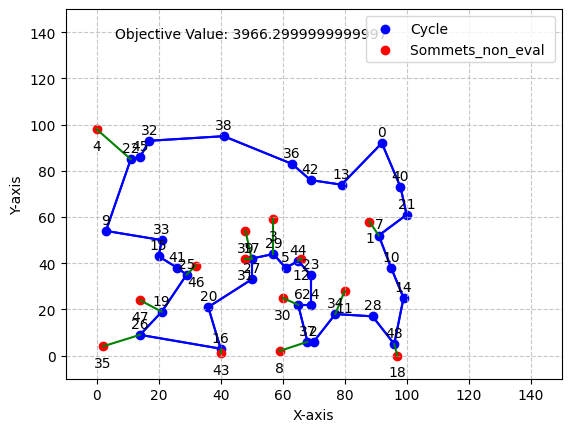

Alpha: 0.5
############################################################################################################
Iterations: 1
###########################################################################################
Performce add point to cycle----------------------------------------------
min objective = 5488.4400000000005
Found better solution, min objective = 5025.490000000002
Add point: 45 to the cycle
###########################################################################################
Performce remove point from cycle----------------------------------------------
min objective = 5488.4400000000005
###########################################################################################
Performce swap point from ----------------------------------------------
min objective = 5488.4400000000005
###########################################################################################
Performce 2-opt for the cycle ----------------------------------------------
min 

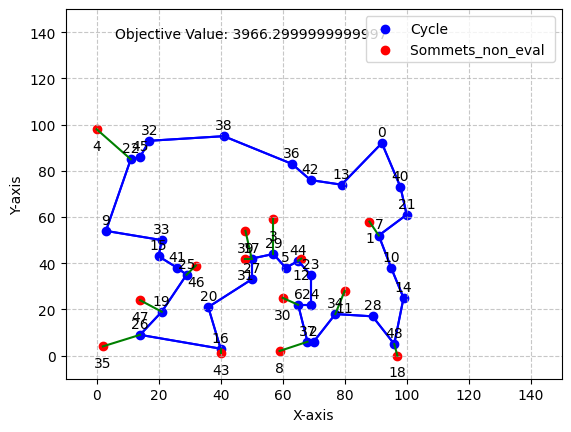

Alpha: 0.75
############################################################################################################
Iterations: 1
###########################################################################################
Performce add point to cycle----------------------------------------------
min objective = 6386.96
Found better solution, min objective = 6020.59
Add point: 24 to the cycle
###########################################################################################
Performce remove point from cycle----------------------------------------------
min objective = 6386.96
###########################################################################################
Performce swap point from ----------------------------------------------
min objective = 6386.96
###########################################################################################
Performce 2-opt for the cycle ----------------------------------------------
min objective of cycle = 2734.69
#############

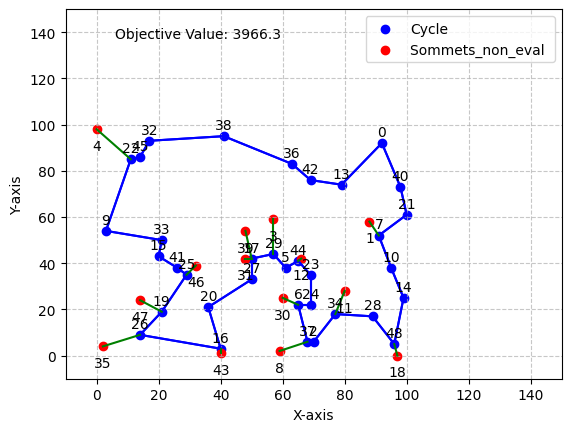

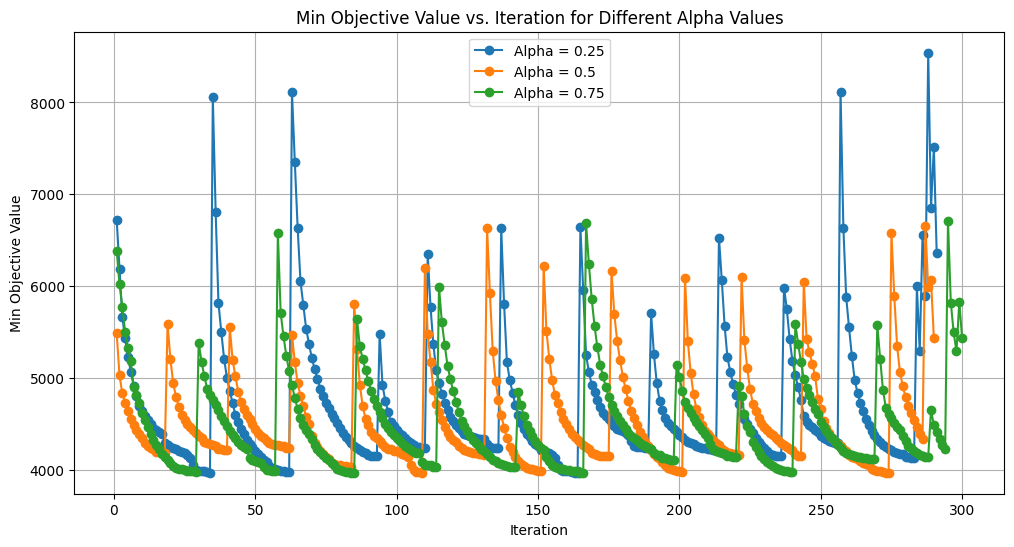

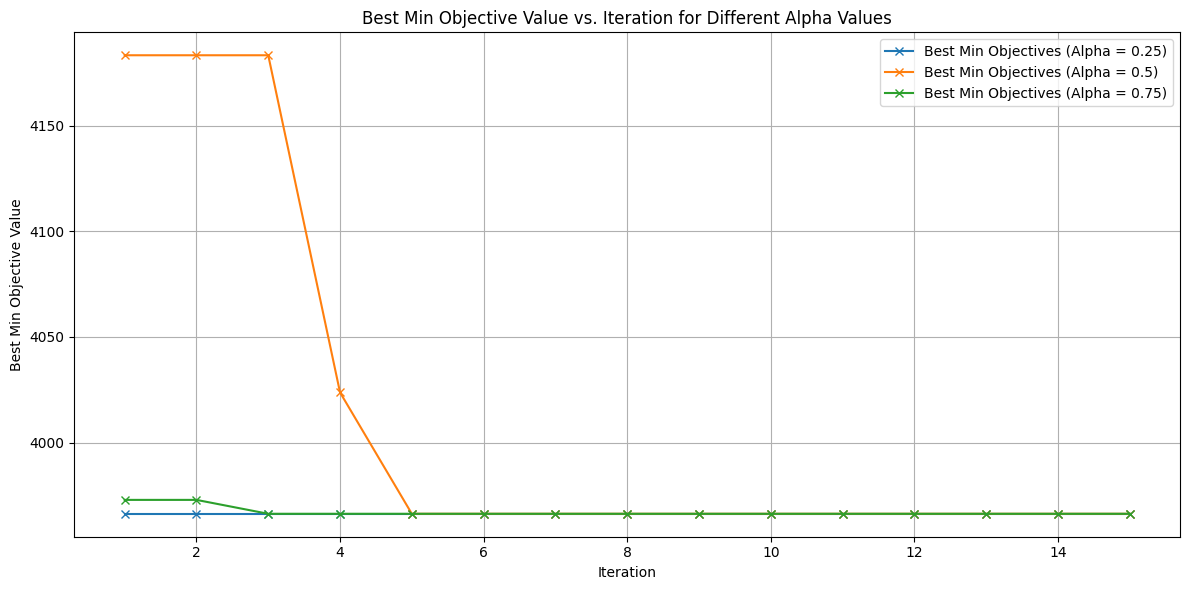

In [ ]:
import matplotlib.pyplot as plt

# Define parameters
max_duration = 300  # 5 minutes in seconds
iterations = 15
alphas = [0.25, 0.5, 0.75]  # Three different values for alpha

# Store results for each alpha
alpha_results = {}

# Loop over different values of alpha
for alpha in alphas:
    print(f"Alpha: {alpha}")
    # Initialize variables to store the best solution for current alpha
    best_min_objective = float('inf')
    best_cycle = None
    best_sommet_non_eval = None
    best_matrix_c = None
    best_matrix_cs = None

    # Store results for each iteration for current alpha
    min_objectives = []
    min_best = []

    start_time = time.time()

    for iter in range(iterations):
        print("############################################################################################################")
        print(f'Iterations: {iter + 1}')

        # Create initial solution using your function
        C1, D1, cycle1, sommet_non_eval1, matrix_c1, matrix_cs1, min_objective1 = my_function(matrix_coord, alpha, beta)
        min_objectives.append(min_objective1)

        # Apply find_neighbor2 to improve the solution
        while True:
            cycle2, sommet_non_eval2, matrix_c2, matrix_cs2, min_objective2 = find_neighbor2(cycle1, sommet_non_eval1,
                                                                                             matrix_c1, matrix_cs1,
                                                                                             min_objective1, C1, D1)

            # Check if the current solution is the best so far
            if min_objective2 < min_objective1:
                cycle1 = cycle2
                sommet_non_eval1 = sommet_non_eval2
                matrix_c1 = matrix_c2
                matrix_cs1 = matrix_cs2
                min_objective1 = min_objective2
                min_objectives.append(min_objective1)

                # Update the best ever found solution
                if min_objective2 < best_min_objective:
                    best_min_objective = min_objective2
                    best_cycle = cycle2.copy()
                    best_sommet_non_eval = sommet_non_eval2.copy()
                    best_matrix_c = matrix_c2.copy()
                    best_matrix_cs = matrix_cs2.copy()
            else:
                break  # Stop if no improvement is made

            # Check if time limit exceeded
            if time.time() - start_time > max_duration:
                print("Time limit exceeded. Exiting loop.")
                break

        min_best.append(best_min_objective)

    # Store results for current alpha
    alpha_results[alpha] = {'min_objectives': min_objectives, 'min_best': min_best,
                            'best_cycle': best_cycle, 'best_sommet_non_eval': best_sommet_non_eval,
                            'best_matrix_c': best_matrix_c, 'best_matrix_cs': best_matrix_cs}
    print(f"Best solution found: min objective = {best_min_objective}")
    print(f"Total time = {time.time() - start_time}")
    scatter_sommets(best_cycle, best_sommet_non_eval, None, best_matrix_c, best_matrix_cs, best_min_objective)
# Plotting the min objective values for each alpha
plt.figure(figsize=(12, 6))

# Plot min objective values
for alpha, result in alpha_results.items():
    plt.plot(range(1, len(result['min_objectives']) + 1), result['min_objectives'], marker='o', label=f'Alpha = {alpha}')
plt.xlabel('Iteration')
plt.ylabel('Min Objective Value')
plt.title('Min Objective Value vs. Iteration for Different Alpha Values')
plt.legend()
plt.grid(True)

# Plot best min objective values
plt.figure(figsize=(12, 6))
for alpha, result in alpha_results.items():
    plt.plot(range(1, len(result['min_best']) + 1), result['min_best'], marker='x', label=f'Best Min Objectives (Alpha = {alpha})')
plt.xlabel('Iteration')
plt.ylabel('Best Min Objective Value')
plt.title('Best Min Objective Value vs. Iteration for Different Alpha Values')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
